In [1]:
from underlying import Underlying
from option import Option, Vanilla
from trader import Trader

import matplotlib.pyplot as plt
from tqdm import tqdm
from quantile_hedging_calculator import *
import numpy as np
import pandas as pd

In [2]:
mu = 0.01
sigma =  0.11
r = 0.05
T = 1
X0 = 100
repeat = 100

## Full hedging - Vanilla Call

In [3]:
K = 80

In [4]:
underlying = Underlying(mu, sigma, r, 250)

In [5]:
_, reality = underlying.simulate_P(repeat, T)

In [6]:
vanilla_call = Vanilla(underlying, K, T, True)

In [7]:
BS_price_call = vanilla_call.get_price(X0, 0)
BS_price_call

23.921881785310987

In [8]:
money_time_call = pd.DataFrame(np.zeros(reality.shape))
delta_time_call = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = BS_price_call)
    money, delta, _ = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_call.loc[i] = money
    delta_time_call.loc[i] = delta

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 19.90it/s]


<AxesSubplot:>

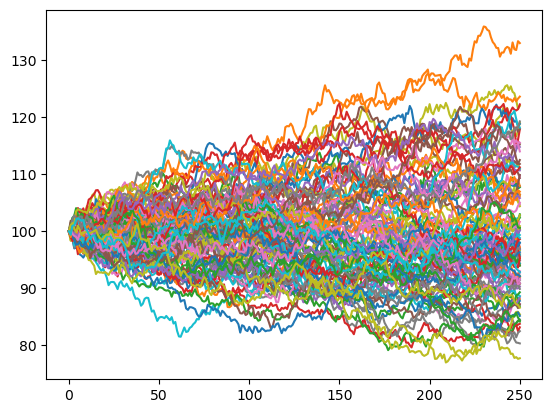

In [9]:
(X0*reality).T.plot(legend = False)

<AxesSubplot:>

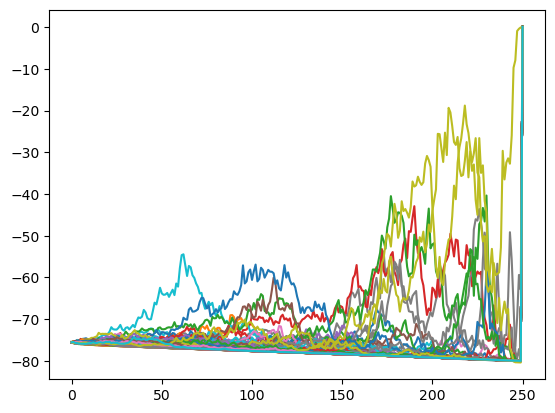

In [10]:
(money_time_call).T.plot(legend = False)

<AxesSubplot:>

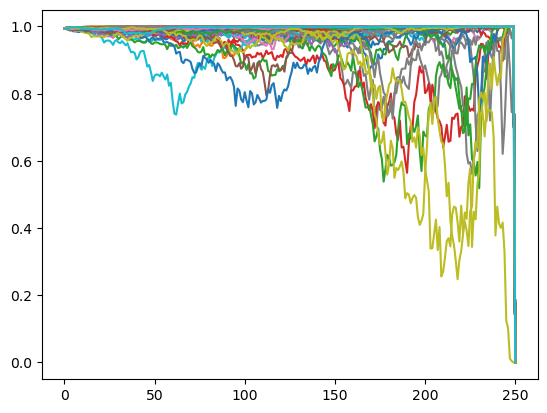

In [11]:
(delta_time_call).T.plot(legend = False)

(array([ 1.,  0.,  0.,  0.,  1.,  4.,  7., 80.,  4.,  3.]),
 array([-0.38194406, -0.32957672, -0.27720938, -0.22484204, -0.1724747 ,
        -0.12010735, -0.06774001, -0.01537267,  0.03699467,  0.08936201,
         0.14172935]),
 <BarContainer object of 10 artists>)

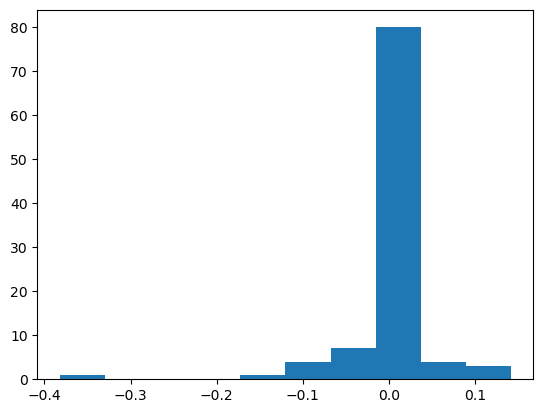

In [12]:
plt.hist(money_time_call.iloc[:,-1])

## Full hedging - Vanilla Put

In [13]:
K = 120

In [14]:
underlying = Underlying(mu, sigma, r, 250)

In [15]:
_, reality = underlying.simulate_P(repeat, T)

In [16]:
vanilla_put = Vanilla(underlying, K, T, False)

In [17]:
BS_price_put = vanilla_put.get_price(X0, 0)
BS_price_put

14.802256916393873

In [18]:
money_time_put = pd.DataFrame(np.zeros(reality.shape))
delta_time_put = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = BS_price_put)
    money, delta, _ = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1)
    money_time_put.loc[i] = money
    delta_time_put.loc[i] = delta

100%|█████████████████████████████████████████| 100/100 [00:05<00:00, 19.53it/s]


<AxesSubplot:>

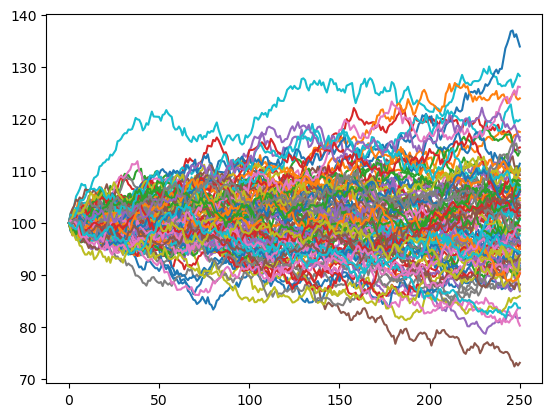

In [19]:
(X0*reality).T.plot(legend = False)

<AxesSubplot:>

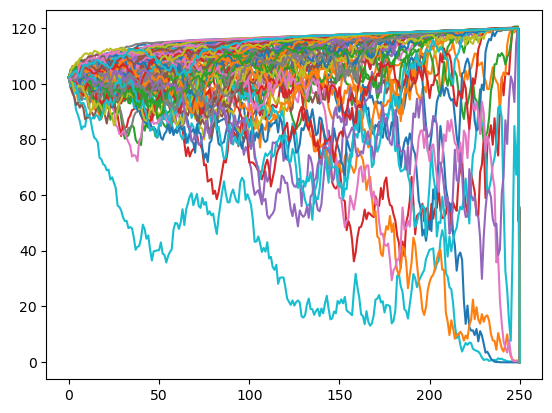

In [20]:
(money_time_put).T.plot(legend = False)

<AxesSubplot:>

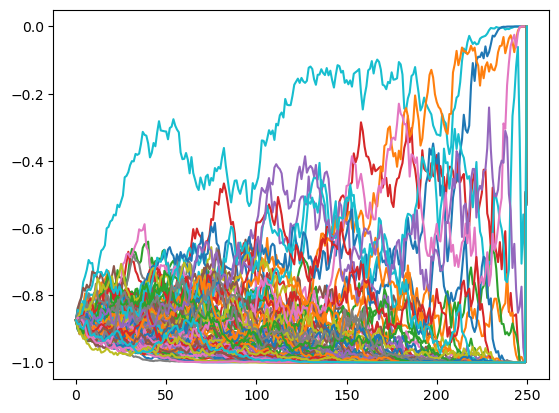

In [21]:
(delta_time_put).T.plot(legend = False)

(array([ 7., 14., 43., 23.,  8.,  2.,  0.,  1.,  1.,  1.]),
 array([-0.23757919, -0.14930117, -0.06102315,  0.02725487,  0.11553288,
         0.2038109 ,  0.29208892,  0.38036693,  0.46864495,  0.55692297,
         0.64520098]),
 <BarContainer object of 10 artists>)

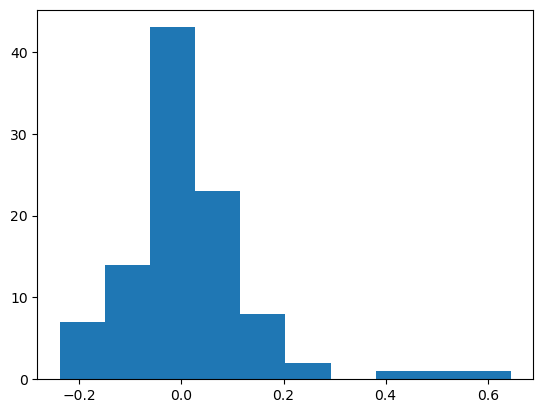

In [22]:
plt.hist(money_time_put.iloc[:,-1])

## Quantile hedging with half of required initial capital- Vanilla Call

In [23]:
K = 80

In [24]:
underlying = Underlying(mu, sigma, r, 250)

In [25]:
_, reality = underlying.simulate_P(repeat, T)

In [26]:
money_time_call = pd.DataFrame(np.zeros(reality.shape))
delta_time_call = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = BS_price_call/2)
    money, delta, success_prob = trader.simulate_hedging(vanilla_call, X0*reality.iloc[[i],:], update_freq = 1, limited_capital = True)
    money_time_call.loc[i] = money
    delta_time_call.loc[i] = delta
print(f'Success probability with initial capital={BS_price_call*0.95:.2f} is: {success_prob}')

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]

Success probability with initial capital=22.73 is: 0.7923


<AxesSubplot:>

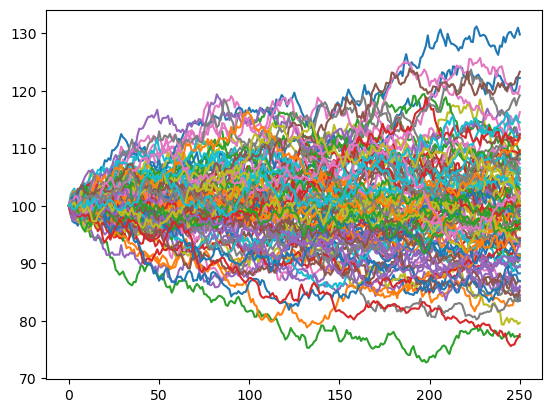

In [27]:
(X0*reality).T.plot(legend = False)

<AxesSubplot:>

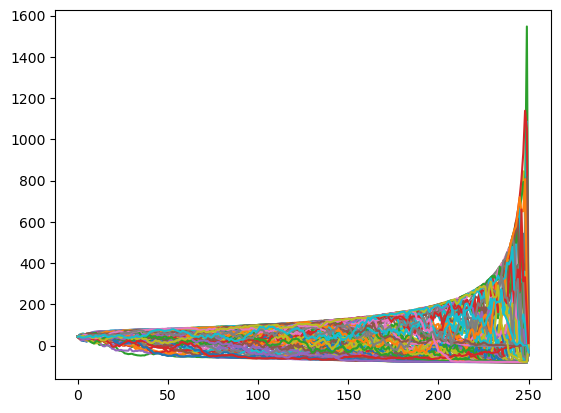

In [28]:
(money_time_call).T.plot(legend = False)

<AxesSubplot:>

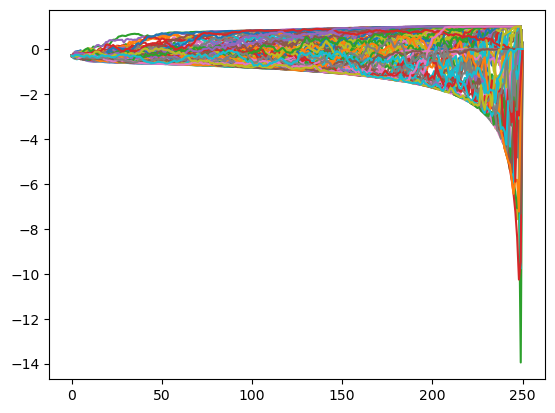

In [29]:
(delta_time_call).T.plot(legend = False)

(array([ 1.,  4.,  3.,  6.,  0.,  0.,  1.,  3., 18., 64.]),
 array([-49.46169169, -44.04710008, -38.63250846, -33.21791685,
        -27.80332523, -22.38873362, -16.974142  , -11.55955038,
         -6.14495877,  -0.73036715,   4.68422446]),
 <BarContainer object of 10 artists>)

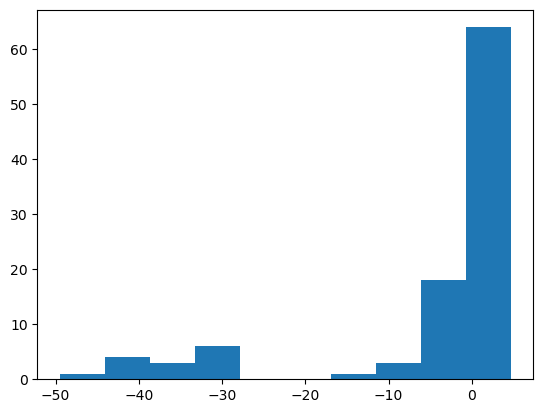

In [30]:
plt.hist(money_time_call.iloc[:,-1])

In [31]:
print(f'Empiric success probability with initial capital={BS_price_call/2:.2f} is: {(money_time_call.iloc[:,-1] >= -0.1 * BS_price_call/2).mean()}')

Empiric success probability with initial capital=11.96 is: 0.74


## Quantile hedging with half of required initial capital- Vanilla Put

In [32]:
K = 120

In [33]:
underlying = Underlying(mu, sigma, r, 250)

In [34]:
_, reality = underlying.simulate_P(repeat, T)

In [35]:
money_time_put = pd.DataFrame(np.zeros(reality.shape))
delta_time_put = pd.DataFrame(np.zeros(reality.shape))
for i in tqdm(range(repeat)):
    trader = Trader(initial_capital = BS_price_put/2)
    money, delta, success_prob = trader.simulate_hedging(vanilla_put, X0*reality.iloc[[i],:], update_freq = 1, limited_capital = True)
    money_time_put.loc[i] = money
    delta_time_put.loc[i] = delta
print(f'Success probability with initial capital={BS_price_put/2:.2f} is: {success_prob}')

100%|█████████████████████████████████████████| 100/100 [00:24<00:00,  4.06it/s]

Success probability with initial capital=7.40 is: 0.4056


<AxesSubplot:>

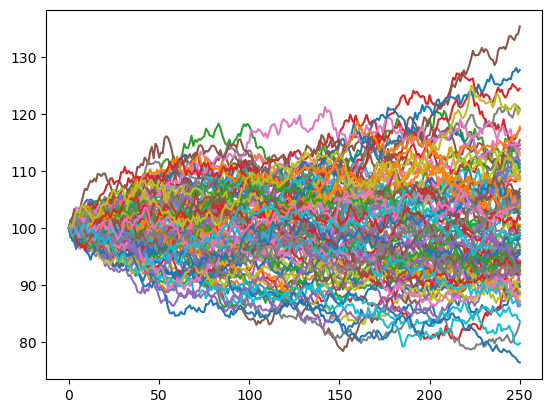

In [36]:
(X0*reality).T.plot(legend = False)

<AxesSubplot:>

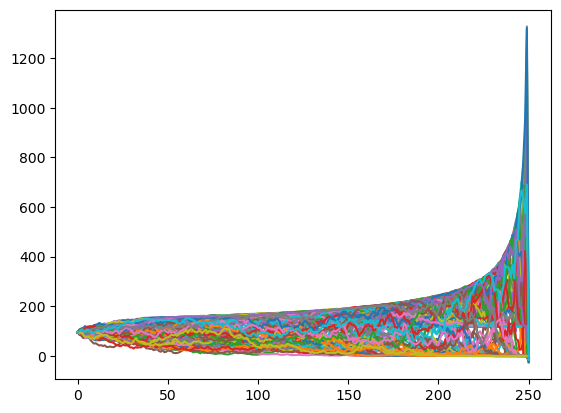

In [37]:
(money_time_put).T.plot(legend = False)

<AxesSubplot:>

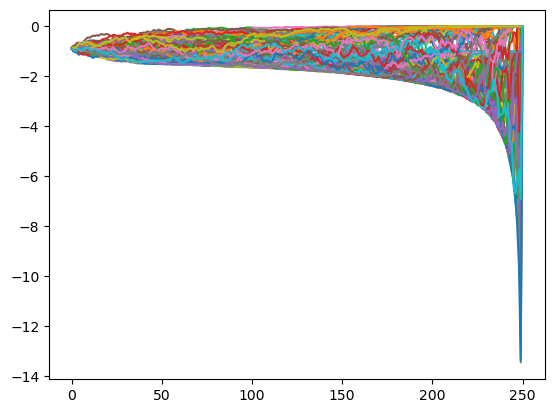

In [38]:
(delta_time_put).T.plot(legend = False)

(array([ 1.,  4.,  5., 17.,  5., 11.,  5.,  5., 32., 15.]),
 array([-26.58532714, -23.60356227, -20.62179741, -17.64003254,
        -14.65826767, -11.67650281,  -8.69473794,  -5.71297307,
         -2.73120821,   0.25055666,   3.23232153]),
 <BarContainer object of 10 artists>)

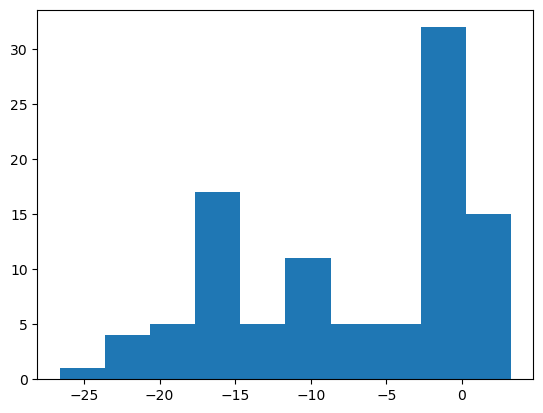

In [39]:
plt.hist(money_time_put.iloc[:,-1])

In [40]:
print(f'Empiric success probability with initial capital={BS_price_put/2:.2f} is: {(money_time_put.iloc[:,-1] >= -0.1 * BS_price_put/2).mean()}')

Empiric success probability with initial capital=7.40 is: 0.4


## Tests on modified payoff properties

### Vanilla call

In [41]:
K = 80
vanilla_call = Vanilla(underlying, K, T, True)

In [42]:
payoff_func_v0, success_prob, c_prob = payoff_from_v0(vanilla_call, BS_price_call/2, X0)
print(f'Success prob for V0={BS_price_call/2:.2f}: {success_prob:.2f}')
payoff_func_prob, success_V0, c_V0 = payoff_from_prob(vanilla_call, success_prob, X0)
print(f'Proper V0 for success prob={success_prob}: {success_V0:.2f}')

Success prob for V0=11.96: 0.79
Proper V0 for success prob=0.7864: 11.88


In [43]:
print(c_prob)

109.4539355867485


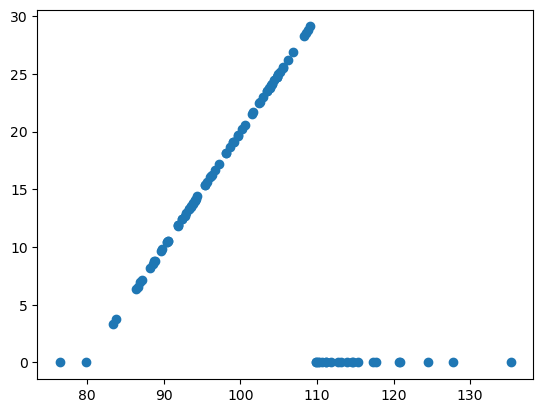

In [44]:
plt.scatter(X0*reality.iloc[:,-1], payoff_func_v0(X0*reality))

In [45]:
print(c_V0)

109.67868324968826


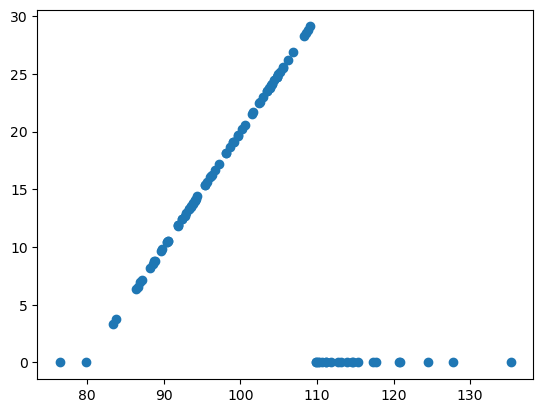

In [46]:
plt.scatter(X0*reality.iloc[:,-1], payoff_func_prob(X0*reality))

### Vanilla put

In [47]:
K = 120
vanilla_put = Vanilla(underlying, K, T, False)

In [48]:
payoff_func_v0, success_prob, c_prob = payoff_from_v0(vanilla_put, BS_price_put/2, X0)
print(f'Success prob for V0={BS_price_put/2:.2f}: {success_prob:.2f}')
payoff_func_prob, success_V0, c_V0 = payoff_from_prob(vanilla_put, success_prob, X0)
print(f'Proper V0 for success prob={success_prob}: {success_V0:.2f}')

Success prob for V0=7.40: 0.40
Proper V0 for success prob=0.4049: 7.39


In [49]:
print(c_prob)

97.7574507081399


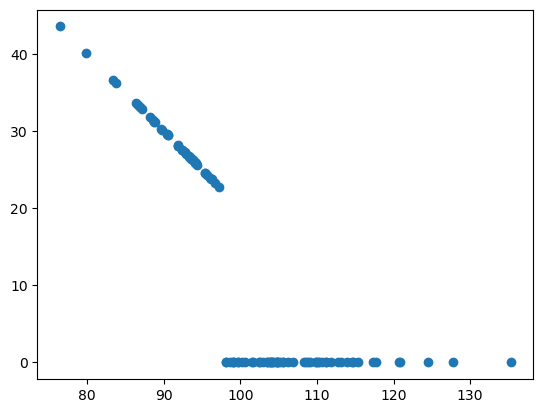

In [50]:
plt.scatter(X0*reality.iloc[:,-1], payoff_func_v0(X0*reality))

In [51]:
print(c_V0)

97.76945847636658


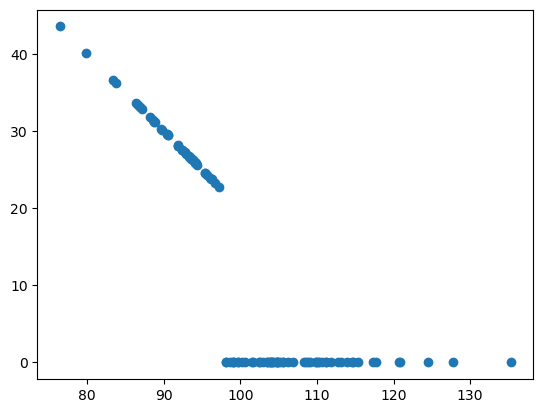

In [52]:
plt.scatter(X0*reality.iloc[:,-1], payoff_func_prob(X0*reality))

## Sensivity analysis on initial capital/BS_price vs success probability

### Vanilla call

In [53]:
K = 80
vanilla_call = Vanilla(underlying, K, T, True)

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.30it/s]


(0.0, 1.0)

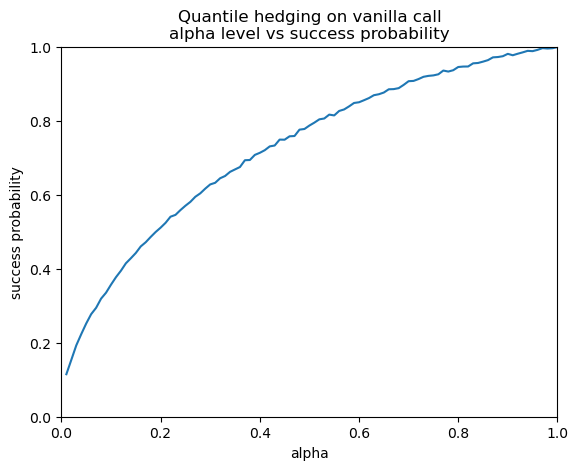

In [54]:
alphas = np.arange(1,101,1)/100
probs = []
for a in tqdm(alphas):
    _, success_prob, _ = payoff_from_v0(vanilla_call, a*BS_price_call, X0)
    probs.append(success_prob)
plt.plot(alphas, probs)
plt.title('Quantile hedging on vanilla call\nalpha level vs success probability')
plt.xlabel('alpha')
plt.ylabel('success probability')
plt.xlim([0,1])
plt.ylim([0,1])

### Vanilla put

In [55]:
K = 120
vanilla_put = Vanilla(underlying, K, T, False)

100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


(0.0, 1.0)

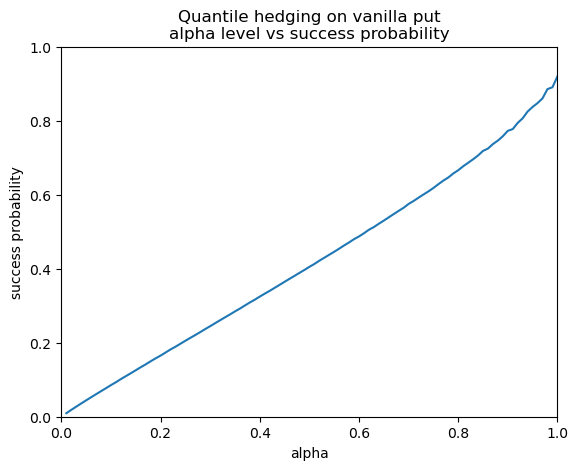

In [56]:
alphas = np.arange(1,101,1)/100
probs = []
for a in tqdm(alphas):
    _, success_prob, _ = payoff_from_v0(vanilla_put, a*BS_price_put, X0)
    probs.append(success_prob)
plt.plot(alphas, probs)
plt.title('Quantile hedging on vanilla put\nalpha level vs success probability')
plt.xlabel('alpha')
plt.ylabel('success probability')
plt.xlim([0,1])
plt.ylim([0,1])